# Recuperação da Informação: 
## Estudo de caso em Corona Dataset
---

## 0. Incializações

### 0.1 Importando bibliotecas

In [1]:
# Libs de sistema
import os
import string
from collections import defaultdict

# Libs para processamento do texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Libs para construção do modelo e avaliação
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix

# Libs para uso geral
import pandas as pd
import numpy as np
import importlib

# Libs de visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Functions para o processamento do texto
from medidas_desempenho import *

# Lib de aceleração com GPU
import torch

# Load do device de processamento do torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device used:', device)

Device used: cuda:0


### 0.2 Carregando Dados

#### 0.2.1 Dados de treino

In [2]:
collection = 'data/20_newsgroups/'
themes = [collection+x+'/' for x in os.listdir(collection)]

x = []
y = []
for theme in themes:
    for file in os.listdir(theme):
        file_name = theme+file
        with open(file_name, 'r', encoding='ISO-8859-1') as fp:
            text = fp.readlines()
    
        x.append(text)
        y.append(theme.split('/')[2])

y = np.array(y)

In [18]:
data = pd.read_csv('data/Corona_NLP_train.csv', encoding='ISO-8859-1')

x = data['OriginalTweet'].values
y = data['Sentiment'].values

#### 0.2.2 Dados de teste

In [3]:
collection = 'data/mini_newsgroups/'
themes = [collection+x+'/' for x in os.listdir(collection)]

x_test = []
y_test = []

for theme in themes:
    for file in os.listdir(theme):
        file_name = theme+file
        with open(file_name, 'r', encoding='ISO-8859-1') as fp:
            text = fp.readlines()
    
        x_test.append(text)
        y_test.append(theme.split('/')[2])

y_test = np.array(y_test)    

In [19]:
data = pd.read_csv('data/Corona_NLP_test.csv', encoding='ISO-8859-1')

x_test = data['OriginalTweet'].values
y_test = data['Sentiment'].values

#### 0.2.3 Visualização dos Dados

In [20]:
print('Tamanho da coleção treino: ', len(x))
print('Tamanho da coleção para query: ', len(x_test))

Tamanho da coleção treino:  41157
Tamanho da coleção para query:  3798


In [21]:
print('Qnt. de classes trabalhadas: ', len(np.unique(y)))
print('Classes trabalhadas: ', np.unique(y))

Qnt. de classes trabalhadas:  5
Classes trabalhadas:  ['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']


## 1. Pré-processamento do texto

### 1.0.1 Definição do método de stemmezar e lista de stopwords

In [22]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.SnowballStemmer(language='english')
stop_words = set(nltk.corpus.stopwords.words('english'))
pontuacao = set(string.punctuation)
table = str.maketrans({x: ' ' for x in string.punctuation})

In [28]:
# Funções para processamento

def pre_process_word(word):
    # word = lemmatizer.lemmatize(word)
    word = stemmer.stem(word)
    return word

def pre_process_text(text):
    text = text.translate(table)
    text = re.sub(r'http\S+', '', text)
    text= re.sub(r'@\S+', '', text)
    text = nltk.tokenize.word_tokenize(text)
    return text

def word_allowed(word):
    if word in stop_words:
        return False

    if word in pontuacao:
        return False
        
    if word.isdecimal():
        return False

    if all(i in string.punctuation for i in word):
        return False
        
    return True

### 1.1 Pipeline de processamento do texto

#### 1.1.1 Processamento para conj. treino

In [29]:
# Processa o texto como um todo, filtra, e processa palavra
aux_x = []
for text in x:
    aux_x.append(' '.join([pre_process_word(word) for word in filter(word_allowed, pre_process_text(text))]))

x_processed = aux_x

#### 1.1.2 Processamento para conj. teste

In [31]:
aux_x = []
for text in x_test:
    aux_x.append(' '.join(pre_process_word(word) for word in filter(word_allowed, pre_process_text(text))))

x_test_processed = aux_x

#### 1.1.3 Limpeza de textos problemáticos

Existem documentos com texto não condizentes com a classe pertencentes (textos que foram removidos em versões mais recentes)

Exemplos:

In [32]:
[x_processed[idx] for idx, text in enumerate(x_processed) if (len(text) < 15)][:10]

['co 51bl8p6vzh',
 'co tox2gobkdg',
 'co bjgtqlbznx',
 'bring knee',
 'chang forev',
 'co d1bbadglmp',
 'at least war',
 'shall pass',
 'meanwhil home',
 'spot meat aldi']

In [33]:
[x_test_processed[idx] for idx, text in enumerate(x_test_processed) if (len(text) < 15)]

[]

In [34]:
drop_train = [idx for idx, text in enumerate(x_processed) if (len(text) < 15)]
drop_test = [idx for idx, text in enumerate(x_test_processed) if (len(text) < 15)]

print(len(drop_train))

58


In [35]:
x_processed = np.delete(x_processed, drop_train)
x_test_processed = np.delete(x_test_processed, drop_test)

y = np.delete(y, drop_train)
y_test = np.delete(y_test, drop_test)

In [36]:
print('Novo tamanho de treino e teste:', len(x_processed), len(x_test_processed))

Novo tamanho de treino e teste: 41099 3798


### 1.2 Visualizando o pré-processamento

In [37]:
# Gera a matriz de contagem de ocorrência do termo por documento

counter_vectorizer = CountVectorizer()
counter_matrix = counter_vectorizer.fit_transform(x_processed)
counter = pd.DataFrame(counter_matrix.todense(), columns=counter_vectorizer.get_feature_names_out())

In [38]:
print('Tamanho do vocabulário inicial: ', len(counter.columns))

Tamanho do vocabulário inicial:  68718


In [39]:
print('Maiores ocorrências de palavras na coleção: ')
pd.DataFrame(counter.sum(axis=0).sort_values(ascending=False).head(10), columns=['Ocorrência'])

Maiores ocorrências de palavras na coleção: 


,Ocorrência
co,24111
coronavirus,18157
covid,15527
price,9120
store,8293
supermarket,7807
food,7338
groceri,6787
peopl,5601
consum,5356


#### 1.2.1 Redução no vocabulário

In [40]:
c = counter.sum(axis=0)
size_reduction = {v: np.where(c>v)[0].shape[0] for v in range(100)}

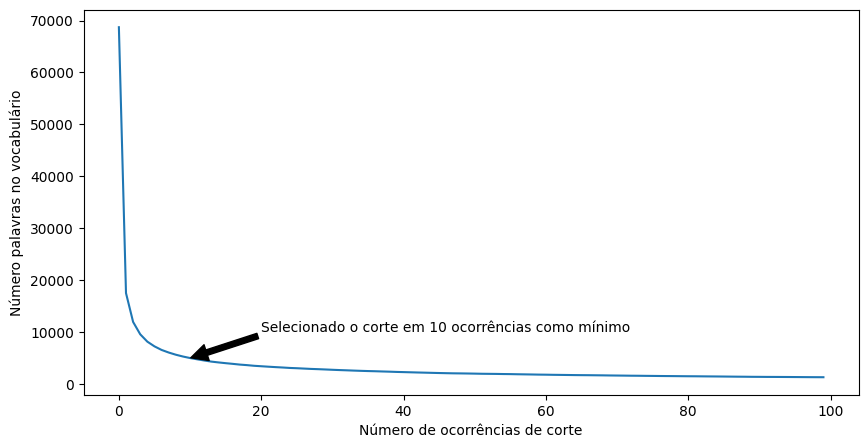

In [44]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data=size_reduction)
plt.annotate('Selecionado o corte em 10 ocorrências como mínimo', xy=(10, size_reduction[10]), xytext=(20, 10000),
            arrowprops=dict(facecolor='black', shrink=0.01),
            )
plt.xlabel('Número de ocorrências de corte')
plt.ylabel('Número palavras no vocabulário')
plt.savefig('figures/PlotOcorr2.png')

In [45]:
counter = counter.loc[:, counter.sum(axis=0).sort_values()>10]

In [79]:
vocabulary = counter.columns.tolist()

# Remoção de algumas palavras com alto valor de ocorrência
vocabulary.remove('co')
vocabulary.remove('covid')
vocabulary.remove('coronavirus')

In [80]:
print('Novo tamanho de vocabulário: ', len(vocabulary))

Novo tamanho de vocabulário:  4953


In [81]:
vocabulary = counter.columns.tolist()

### 1.3 Calculo de TF-IDF 

In [82]:
# Recontagem baseado no vocabulário reduzido

counter_vectorizer = CountVectorizer(vocabulary=vocabulary)
counter_matrix = counter_vectorizer.fit_transform(x_processed)
counter = pd.DataFrame(counter_matrix.todense(), columns=counter_vectorizer.get_feature_names_out())

In [83]:
# Cálculo do TF-IDF para a modelagem

tfidf_vectorizer = TfidfTransformer()
tfidf_matrix = tfidf_vectorizer.fit_transform(counter_matrix)
tfidf = pd.DataFrame(tfidf_matrix.todense(), columns=counter_vectorizer.get_feature_names_out())

In [84]:
# Contagem de ocorrências no conjunto de teste

counter_matrix_test = counter_vectorizer.transform(x_test_processed)
counter_test = pd.DataFrame(counter_matrix_test.todense(), columns=counter_vectorizer.get_feature_names_out())

In [85]:
# Calculo do TF-IDF para as queries em relação aos termos da coleção

tfidf_test_matrix = tfidf_vectorizer.transform(counter_matrix_test)
tfidf_test = pd.DataFrame(tfidf_test_matrix.todense(), columns=tfidf_vectorizer.get_feature_names_out())

---
## 2. Modelagem

### 2.1 Modelo vetorial

#### 2.1.1 Load dos modelos (Arquivo Models)

In [86]:
from modelos import ModeloVetorial
labels = sorted(np.unique(y))
precisions_calc = [10, 20, 50, 100]

#### 2.1.2 Geração do modelo e treinamento

In [87]:
md = ModeloVetorial()
md.fit(x=tfidf, y=y)

#### 2.1.3 Predição das queries

In [88]:
predict = []
for query_test in tfidf_test.values:
    predict.append(md.predict(query_test))

#### 2.1.4 Calculo das medidas de desempenho

In [89]:
measures = pd.DataFrame([calcula_measures(y_pred, y_true, precisions_calc + ['map']) for y_pred, y_true in zip(predict, y_test)])

In [90]:
# Calculo das matrizes de confusão
cf_per_prec = {}

for prec in precisions_calc:
    cf_per_prec[prec] = np.zeros(shape=(len(labels), len(labels)))

for y_pred, y_true in zip(predict, y_test):
    for prec, cf in calcula_matriz_confusao(y_pred, y_true, precisions_calc, labels=np.unique(y)).items():
        cf_per_prec[prec] += cf

#### 2.1.5 Visualização dos resultados

In [91]:
r_vetorial = pd.DataFrame(measures)

In [92]:
pd.DataFrame(r_vetorial.mean()).T

,P@10,P@20,P@50,P@100,MAP
0,0.283939,0.276316,0.265766,0.260326,0.235446


In [93]:
r_vetorial.insert(0, 'Class', y_test)

In [94]:
r_vetorial.groupby(by='Class').mean().sort_values(by='P@10', ascending=False)

,P@10,P@20,P@50,P@100,MAP
Class,,,,,
Extremely Positive,0.315860,0.311853,0.296227,0.286494,0.231647
Extremely Negative,0.315034,0.301182,0.284358,0.271385,0.204124
Positive,0.302746,0.301690,0.294446,0.292017,0.287419
Negative,0.288665,0.277954,0.270432,0.267800,0.252046
Neutral,0.186591,0.176575,0.166785,0.163376,0.161651


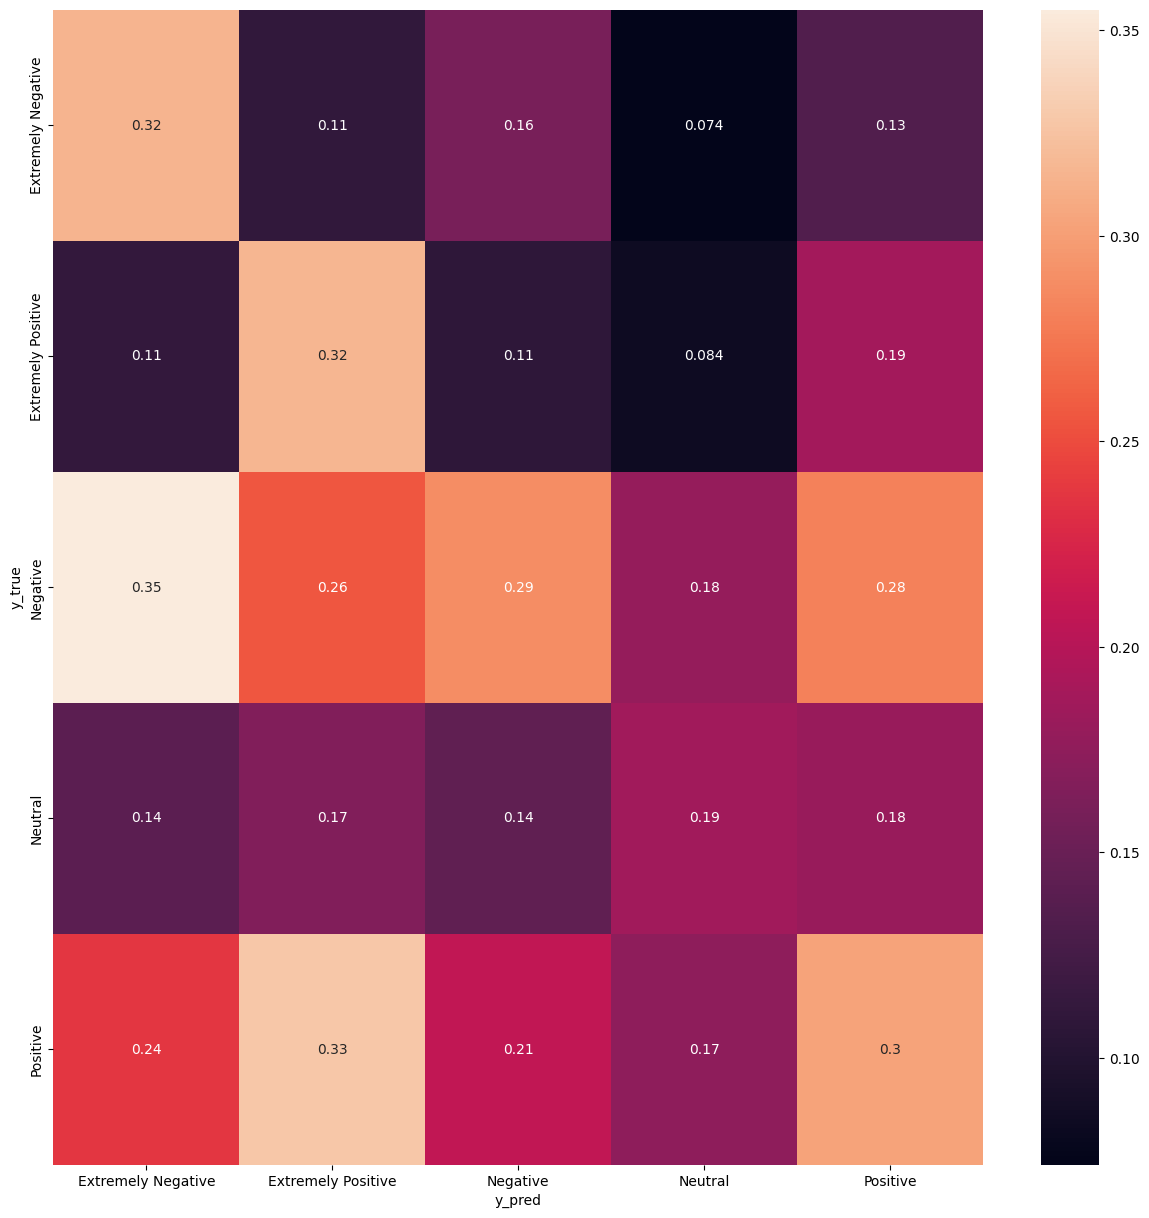

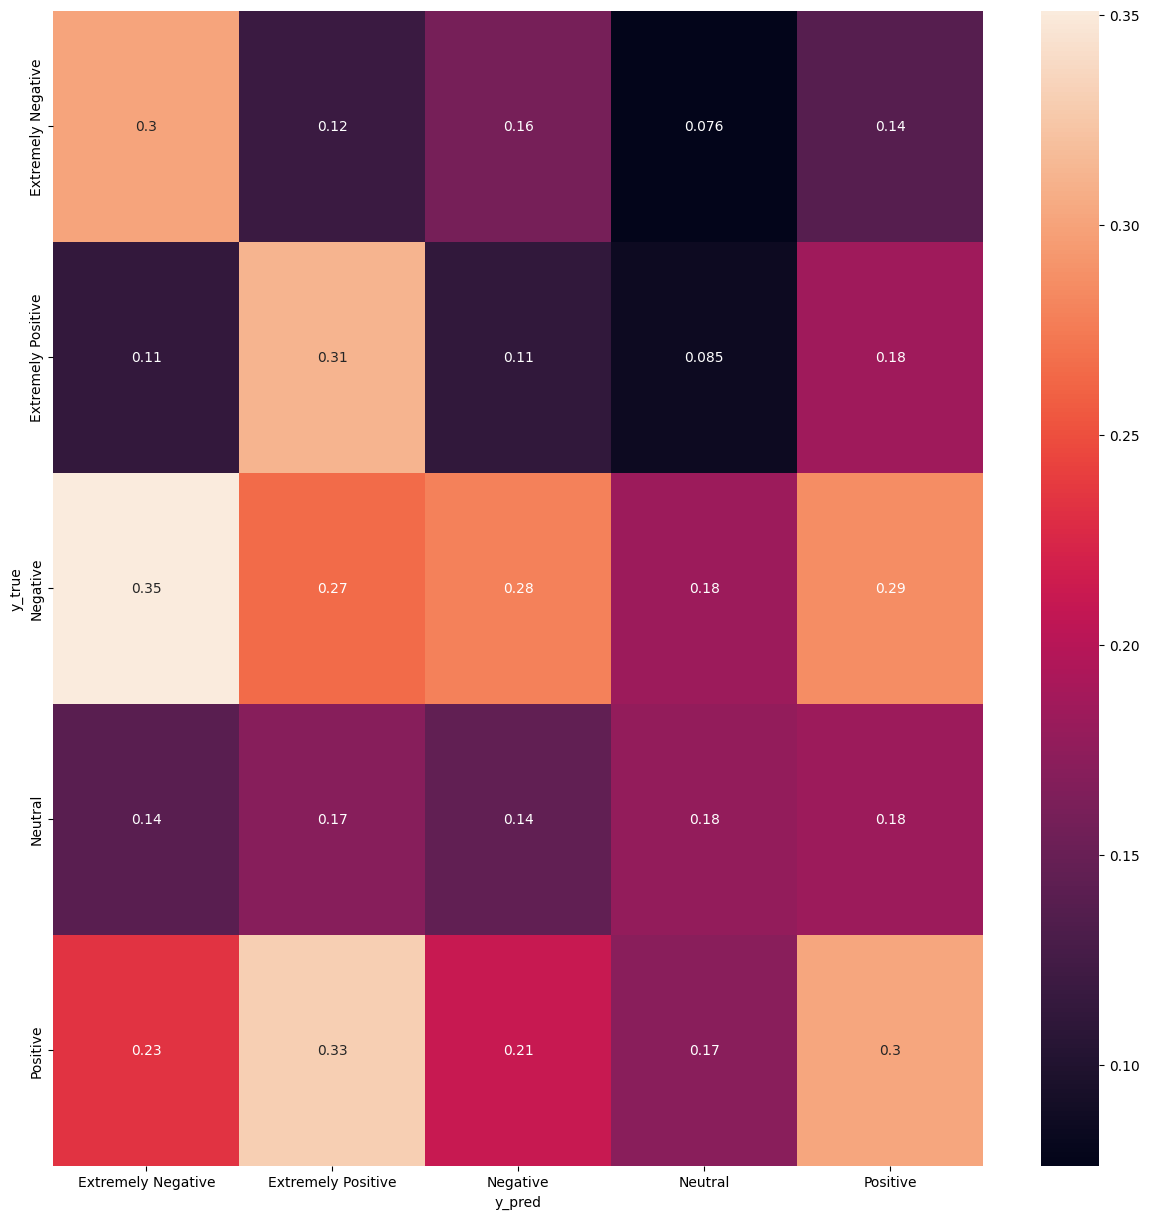

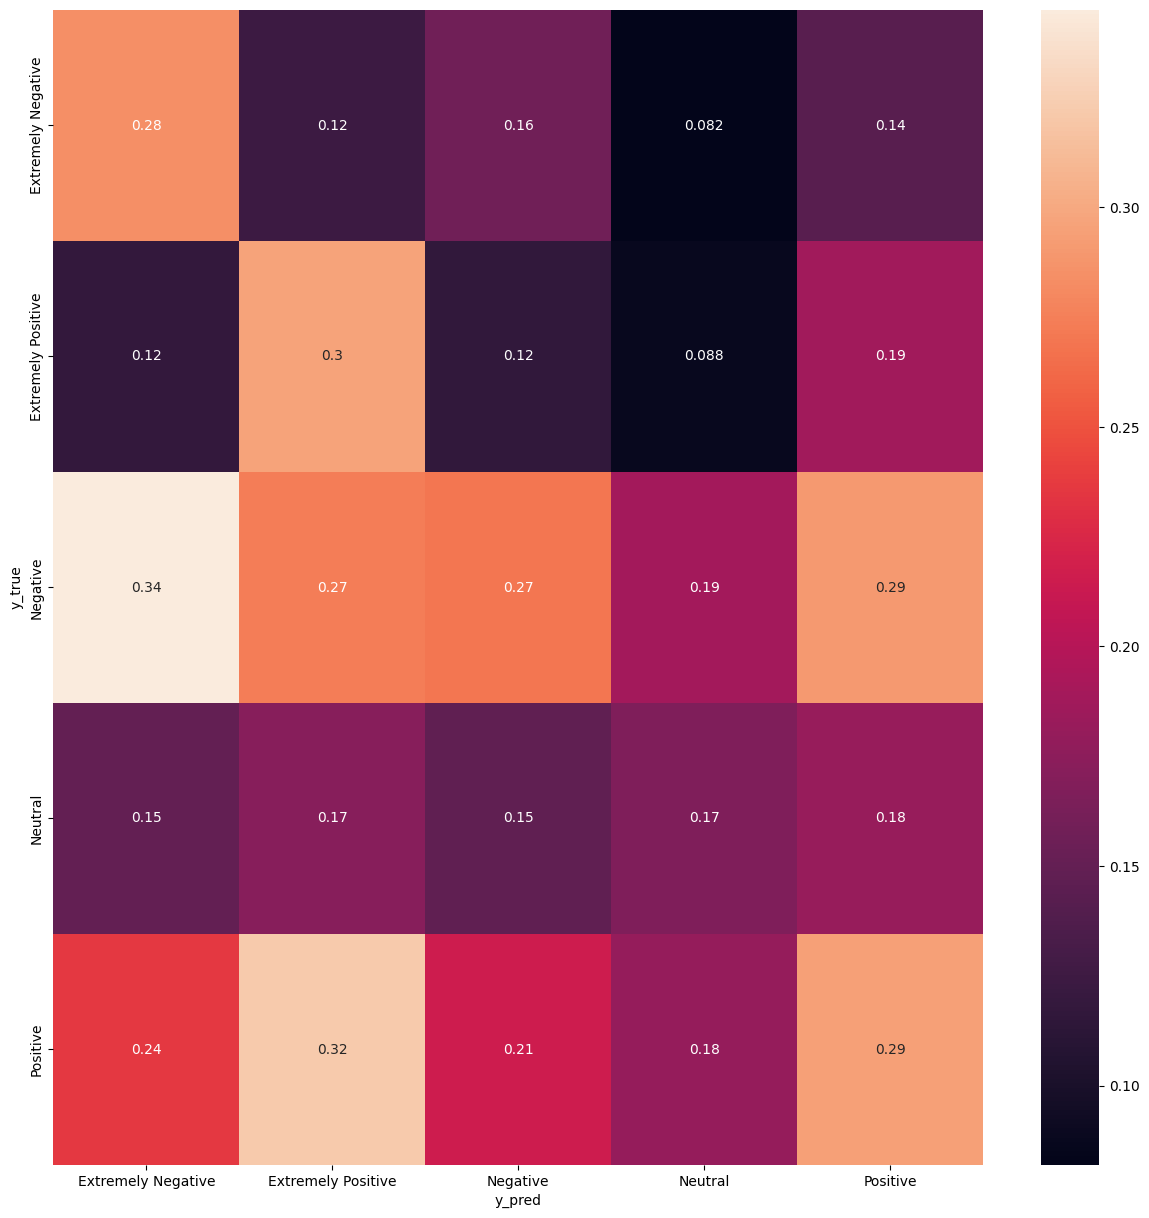

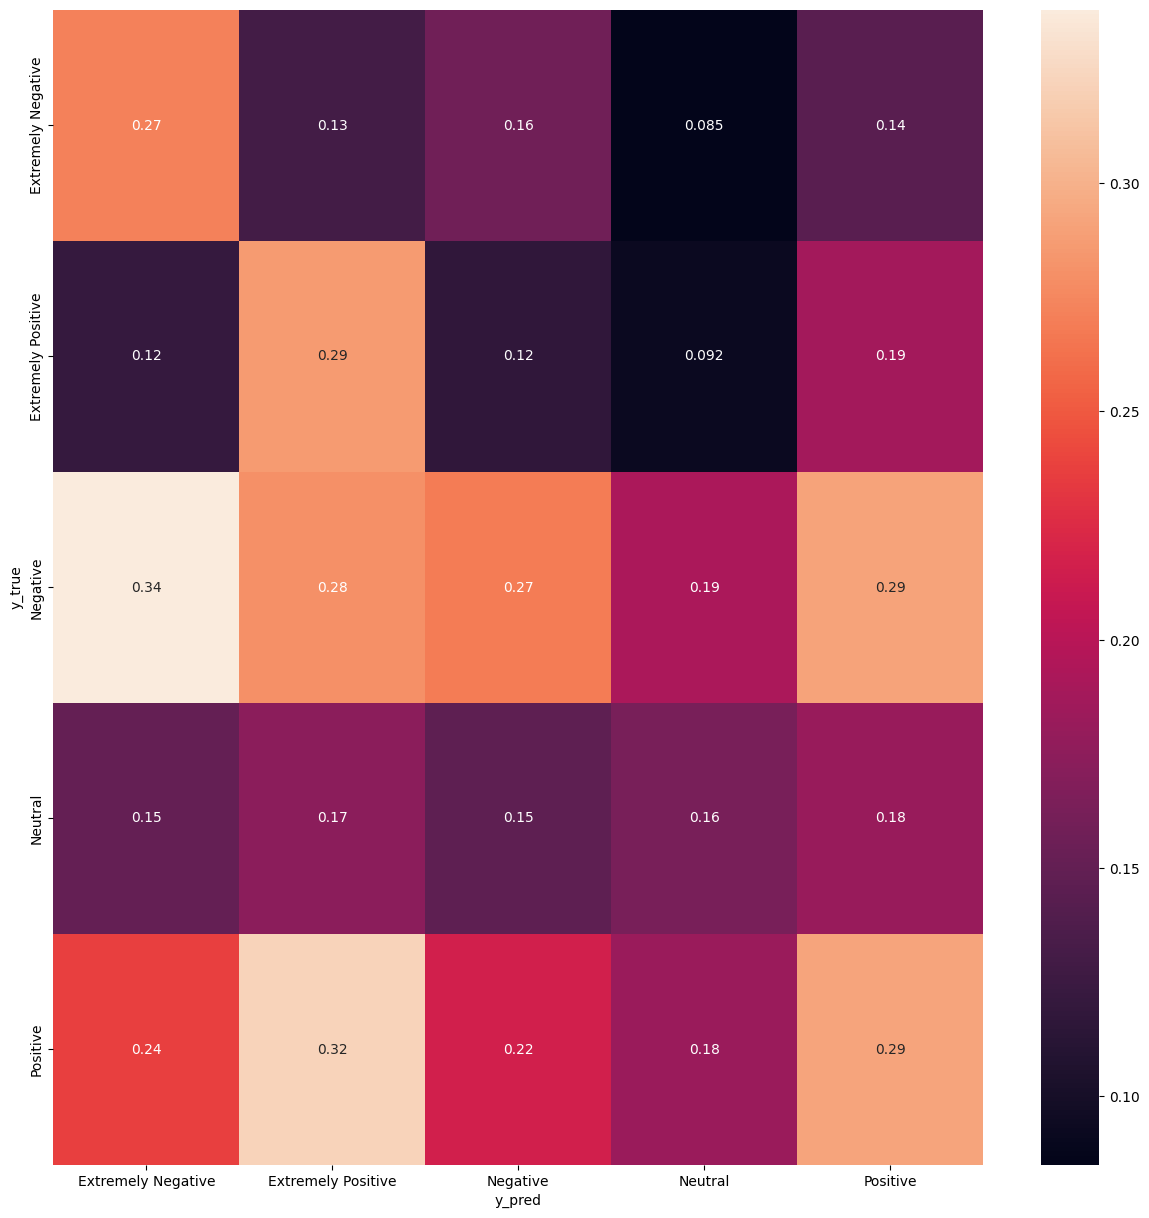

In [95]:
for prec in precisions_calc:
    v = pd.DataFrame(np.around(cf_per_prec[prec]/cf_per_prec[prec].sum(axis=1), 3), columns=labels, index=labels)
    
    fig = plt.figure(figsize=(15, 15))
    sns.heatmap(v, annot=True)
    plt.ylabel('y_true')
    plt.xlabel('y_pred')
    fig.savefig(f'figures-corona/cf_matrix/cf_{prec}.png', bbox_inches='tight')

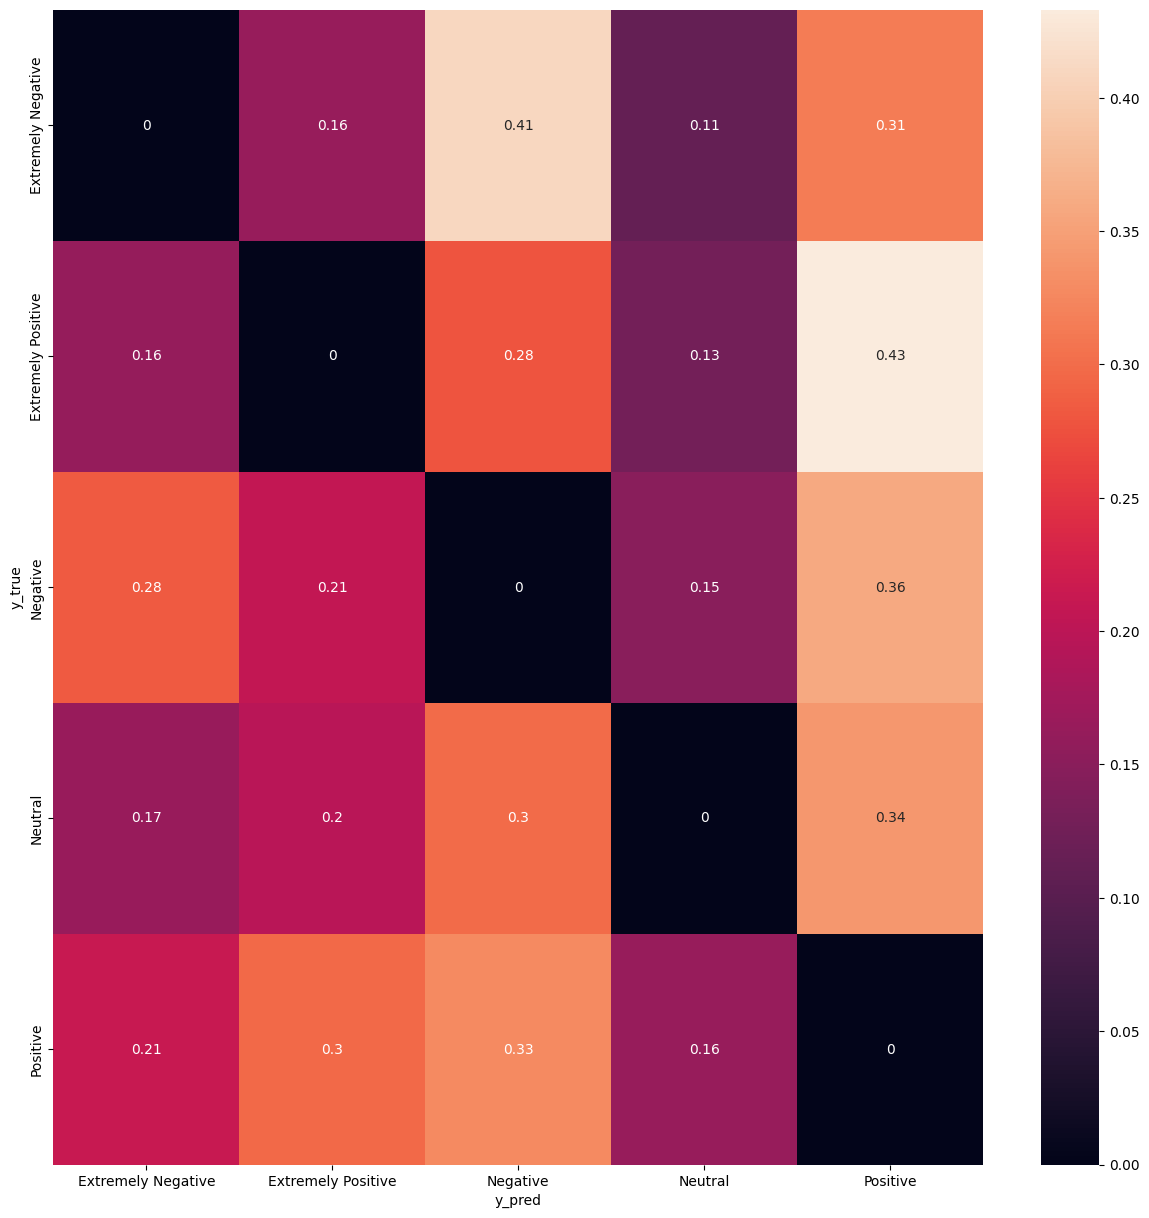

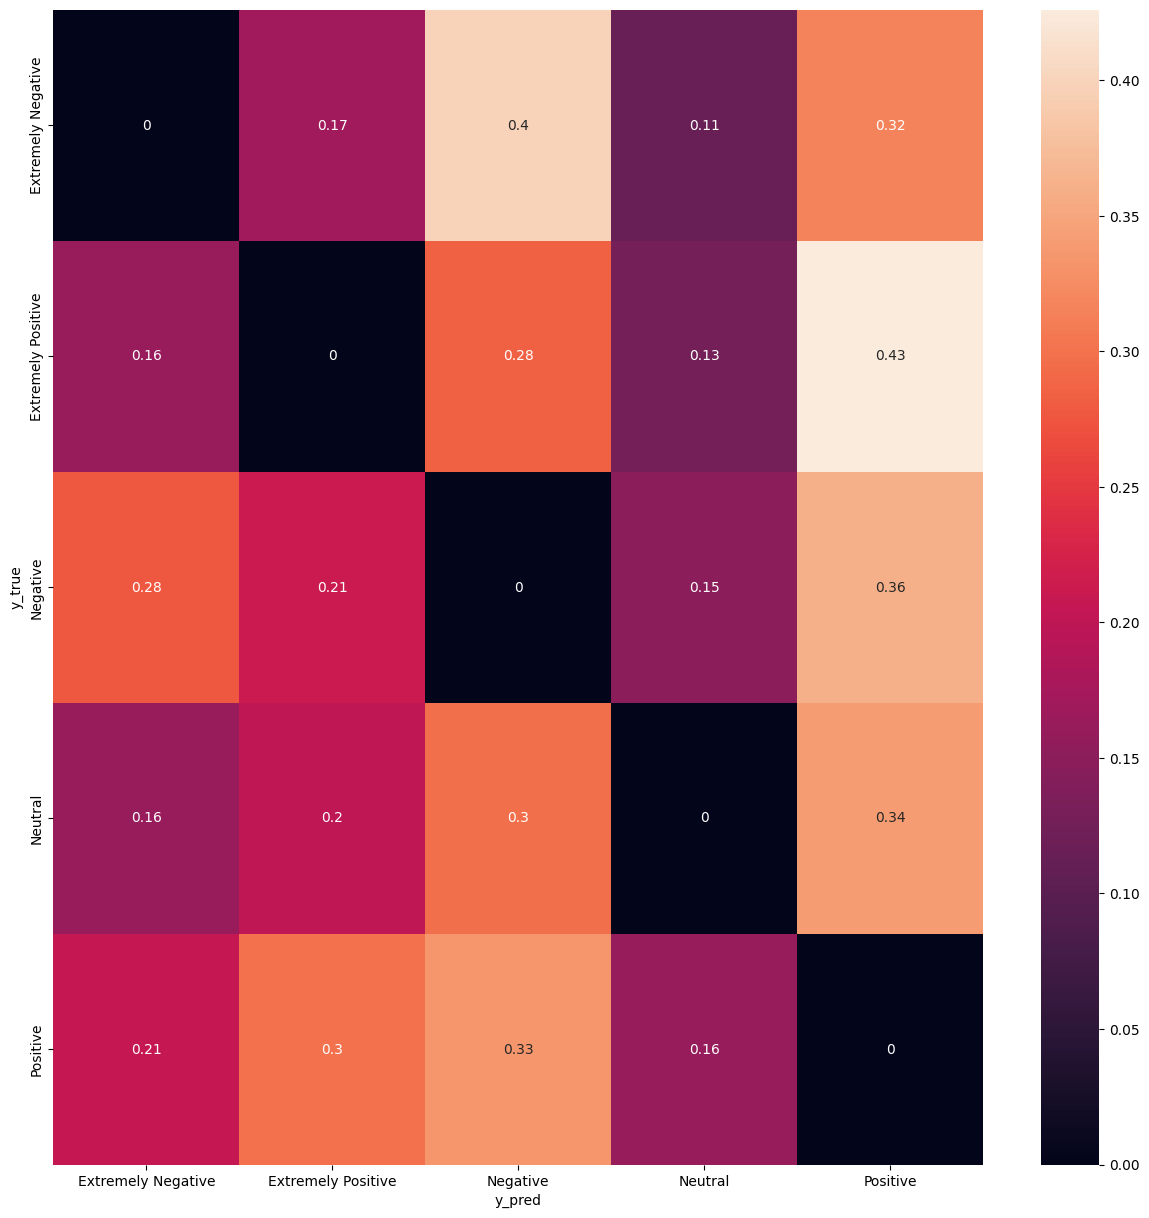

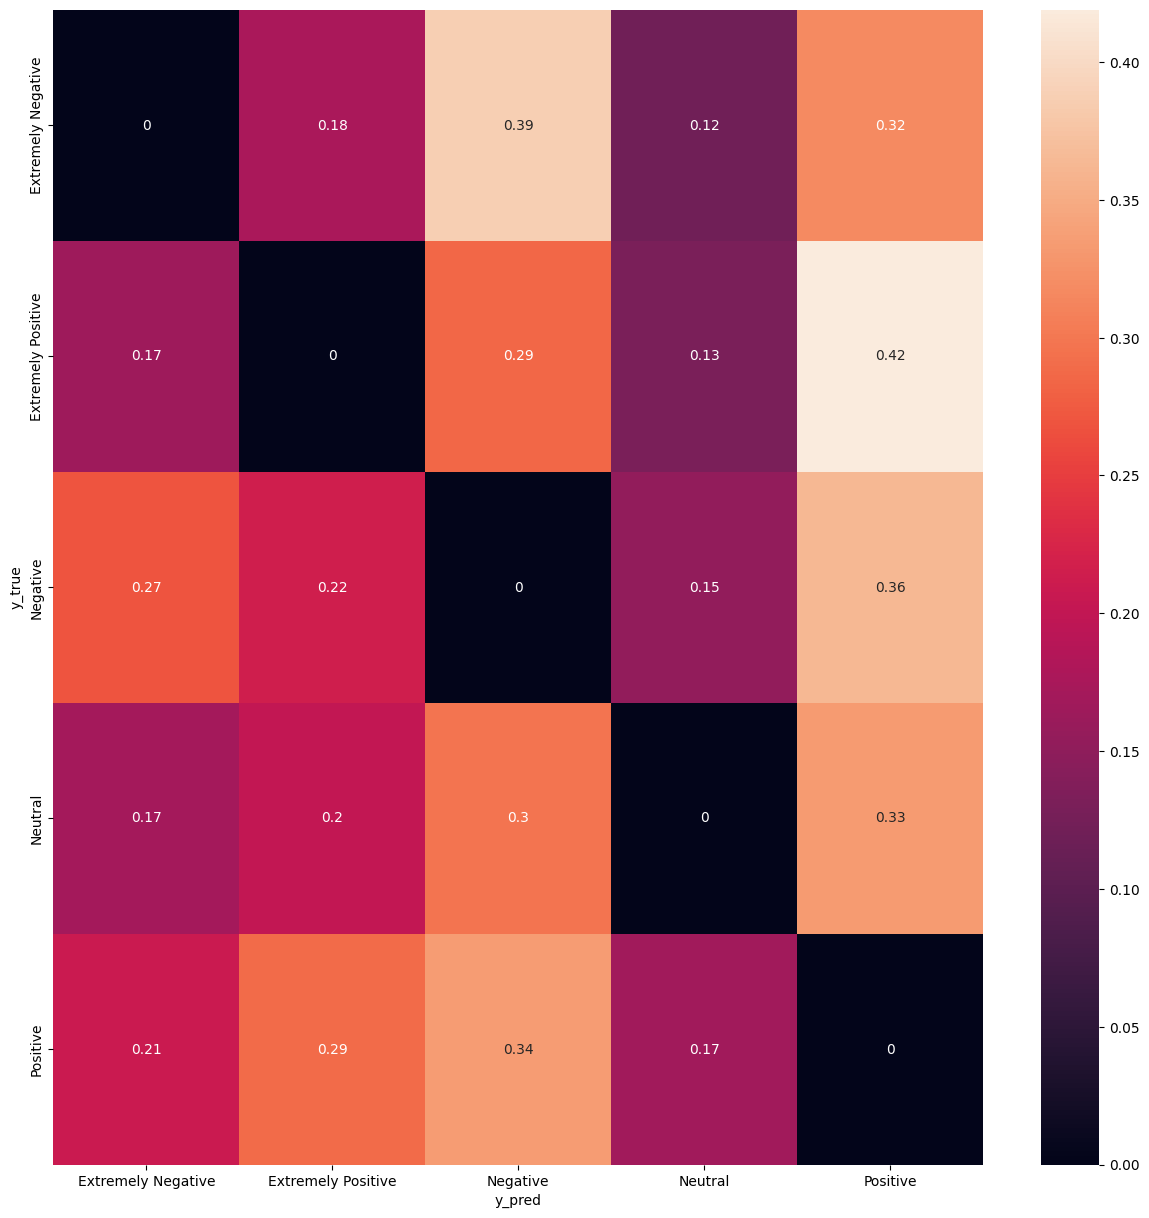

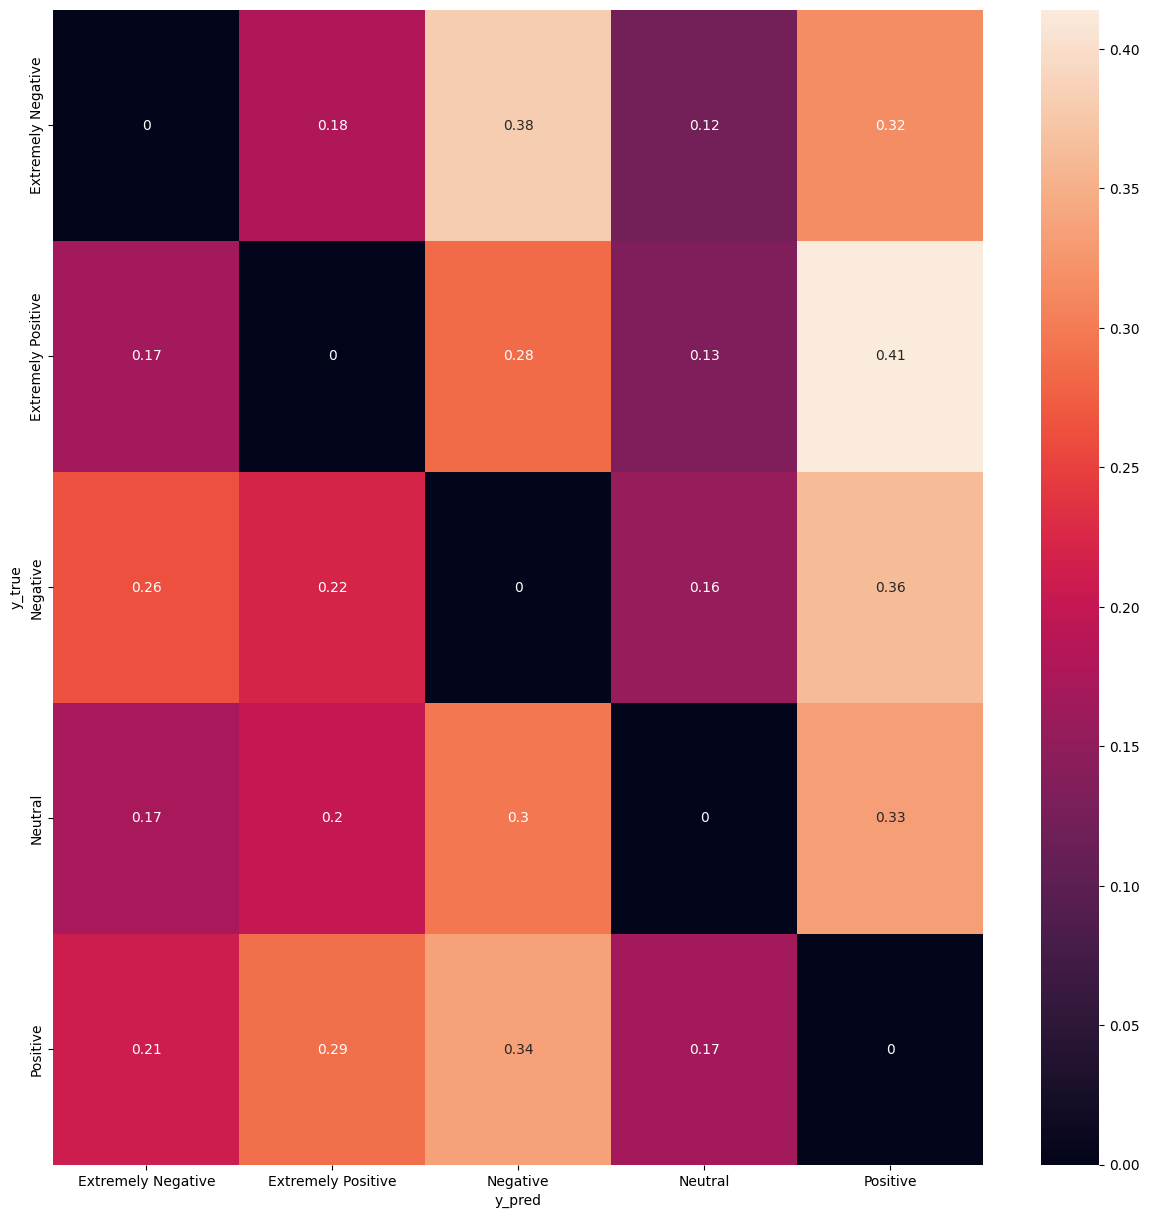

In [96]:
for prec in precisions_calc:
    v = pd.DataFrame(np.around(fill_diagonal(cf_per_prec[prec], 0)/fill_diagonal(cf_per_prec[prec], 0).sum(axis=1).reshape(-1, 1), 3), columns=labels, index=labels)
    
    fig = plt.figure(figsize=(15, 15))
    sns.heatmap(v, annot=True)
    plt.ylabel('y_true')
    plt.xlabel('y_pred')
    fig.savefig(f'figures-corona/cf_matrix/cf_diagonal_0_{prec}.png', bbox_inches='tight')

### 2.2 Modelo Probabilistico (BM25)

#### 2.2.1 Load dos modelos (Arquivo Models)

In [97]:
from modelos import ModeloBM25

#### 2.2.2 Geração do modelo e treinamento

In [98]:
model_bm25 = ModeloBM25()
model_bm25.fit(x=counter, y=y)

#### 2.2.3 Predição das queries

In [99]:
predict_bm25 = []
for query_test in tfidf_test.values:
    predict_bm25.append(model_bm25.predict(query_test))

#### 2.2.4 Calculo das medidas de desempenho

In [100]:
measures_bm25 = pd.DataFrame([calcula_measures(y_pred, y_true, precisions_calc + ['map']) for y_pred, y_true in zip(predict_bm25, y_test)])

In [101]:
# Calculo das matrizes de confusão
cf_per_prec_bm25 = {}

for prec in precisions_calc:
    cf_per_prec_bm25[prec] = np.zeros(shape=(len(labels), len(labels)))

for y_pred, y_true in zip(predict_bm25, y_test):
    for prec, cf in calcula_matriz_confusao(y_pred, y_true, precisions_calc, labels=np.unique(y)).items():
        cf_per_prec_bm25[prec] += cf

#### 2.1.4 Visualização dos resultados

In [102]:
r_vetorial_bm25 = pd.DataFrame(measures_bm25)

In [103]:
pd.DataFrame(r_vetorial_bm25.mean()).T

,P@10,P@20,P@50,P@100,MAP
0,0.283044,0.275882,0.266298,0.261448,0.233363


In [104]:
r_vetorial_bm25.insert(0, 'Class', y_test)

In [105]:
r_vetorial_bm25.groupby(by='Class').mean().sort_values(by='P@10', ascending=False)

,P@10,P@20,P@50,P@100,MAP
Class,,,,,
Extremely Positive,0.336895,0.319366,0.294624,0.282688,0.210883
Extremely Negative,0.321622,0.308784,0.293345,0.281199,0.200274
Positive,0.303168,0.304329,0.301901,0.298828,0.286582
Negative,0.268588,0.262776,0.259328,0.258425,0.247588
Neutral,0.187561,0.180856,0.170275,0.169903,0.181423


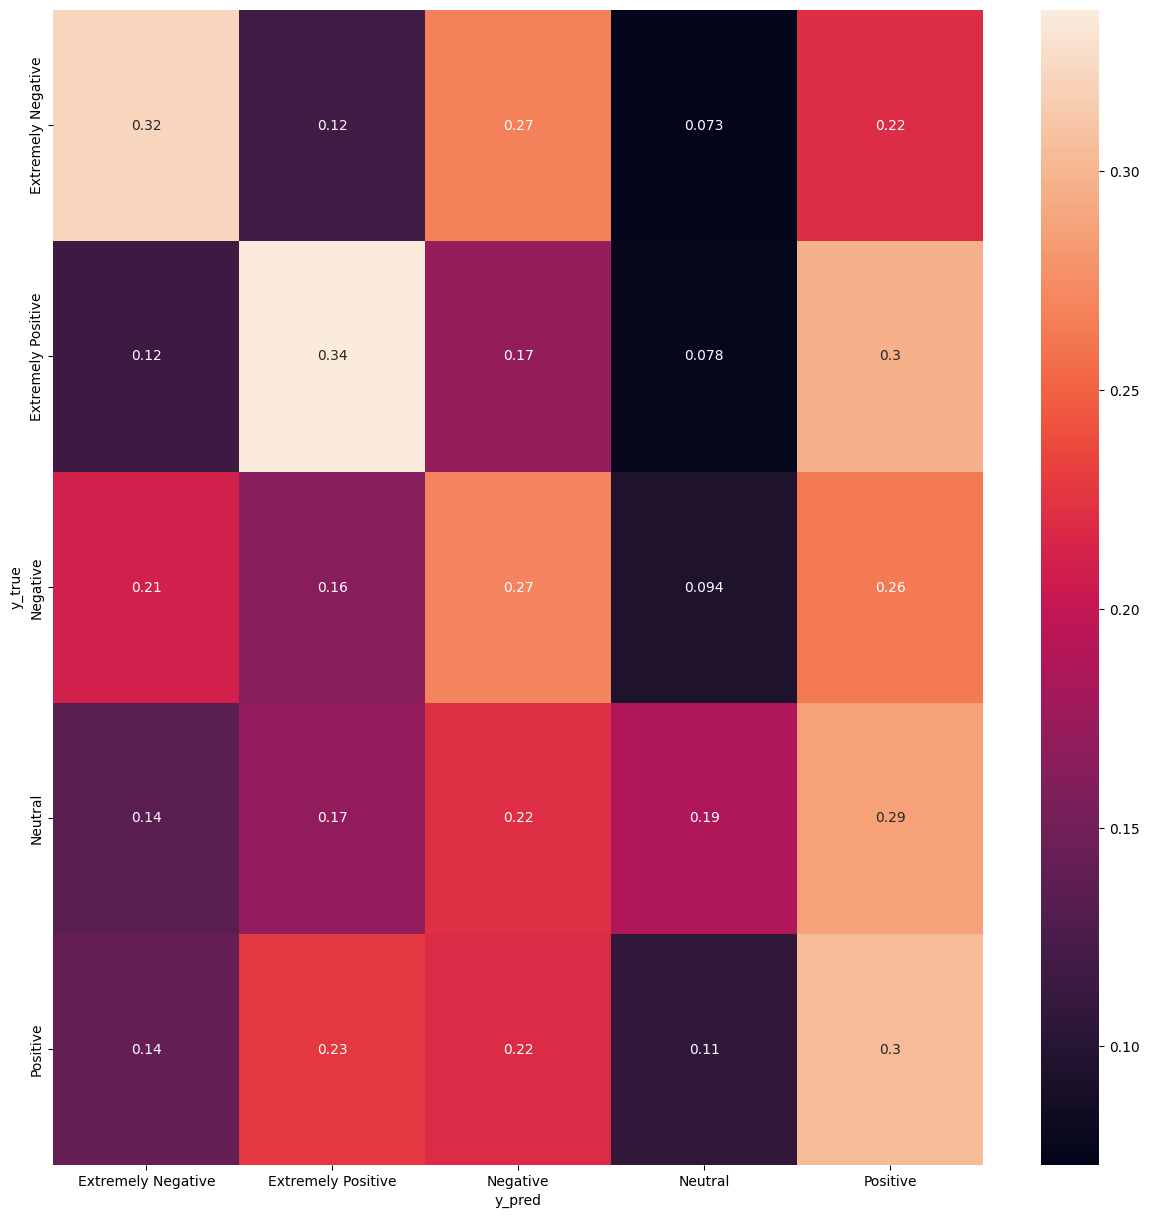

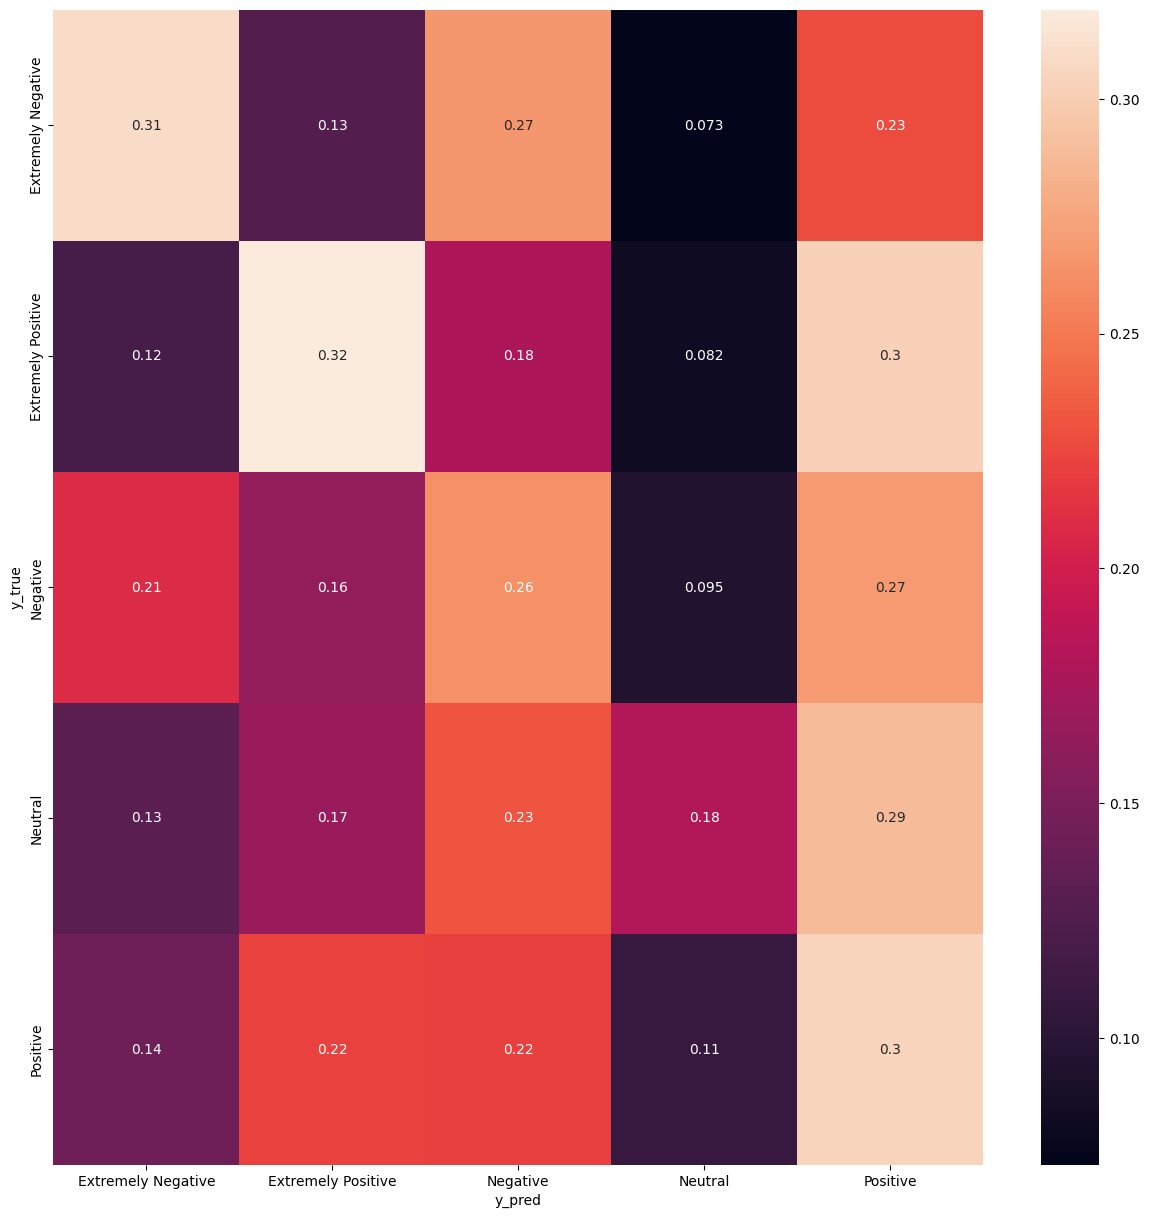

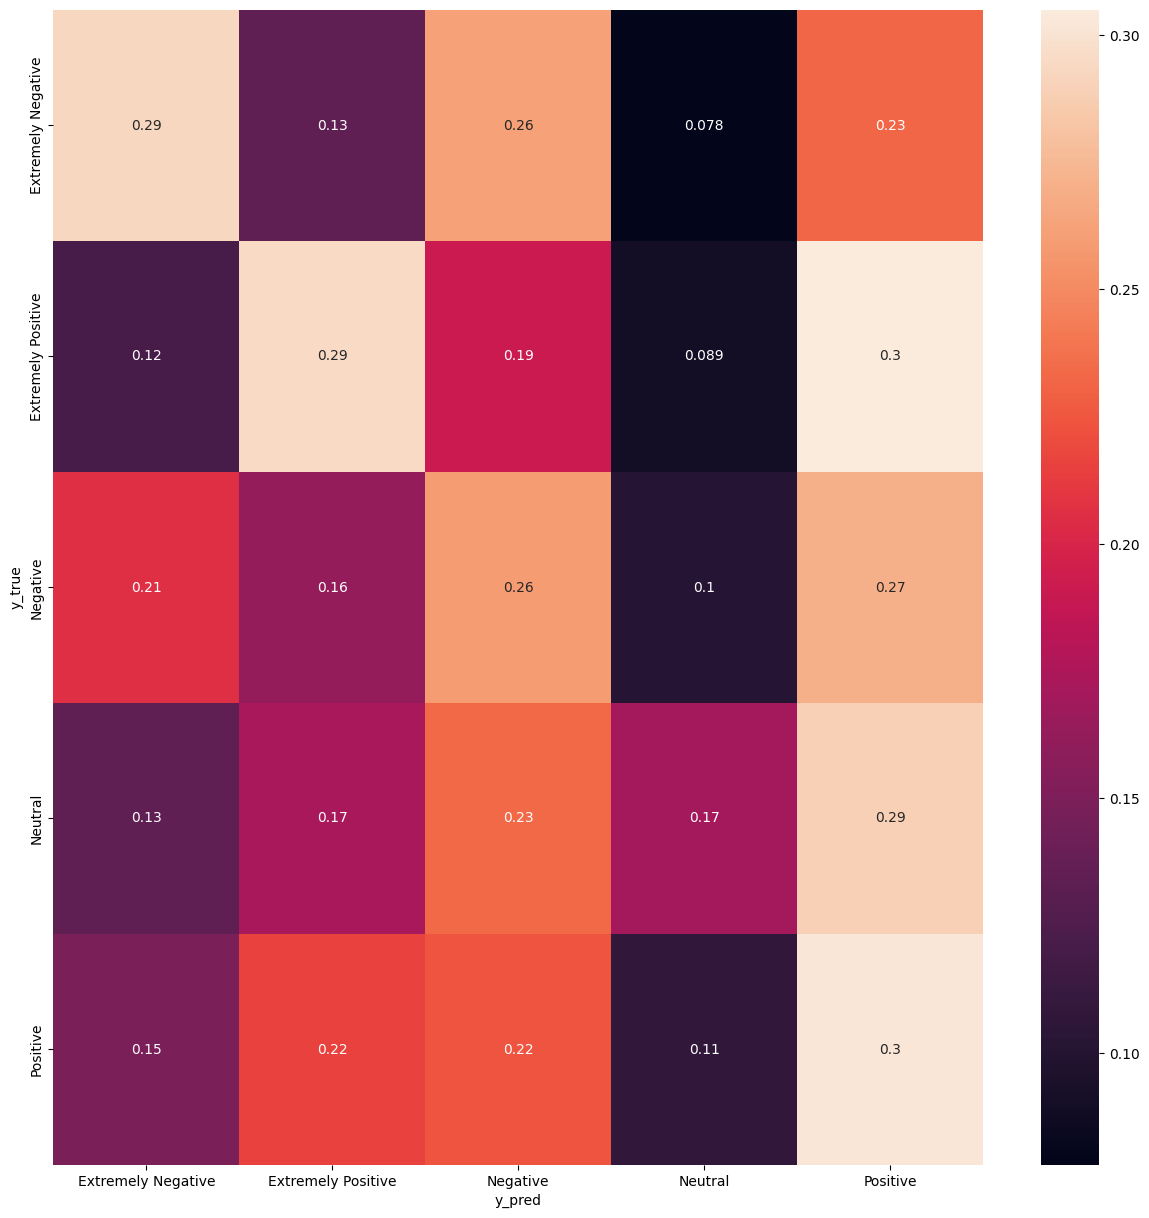

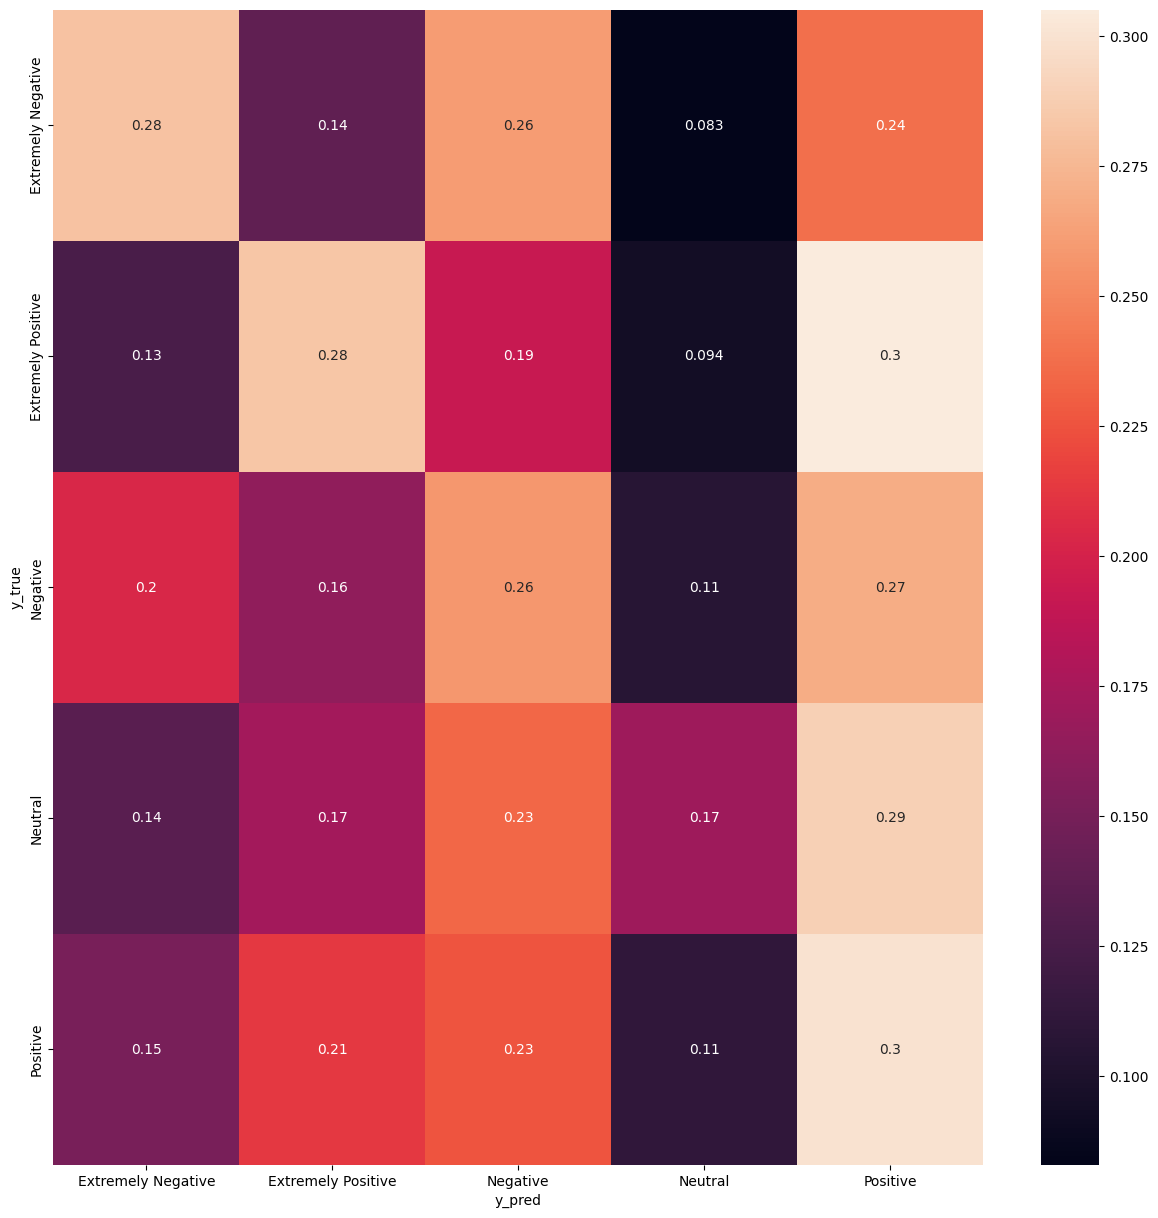

In [106]:
for prec in precisions_calc:
    v = pd.DataFrame(np.around(cf_per_prec_bm25[prec]/(cf_per_prec_bm25[prec].sum(axis=1)).reshape(-1, 1), 3), columns=labels, index=labels)
    
    fig = plt.figure(figsize=(15, 15))
    sns.heatmap(v, annot=True)
    plt.ylabel('y_true')
    plt.xlabel('y_pred')
    fig.savefig(f'figures-corona/cf_matrix/cf_bm25_{prec}.png', bbox_inches='tight')

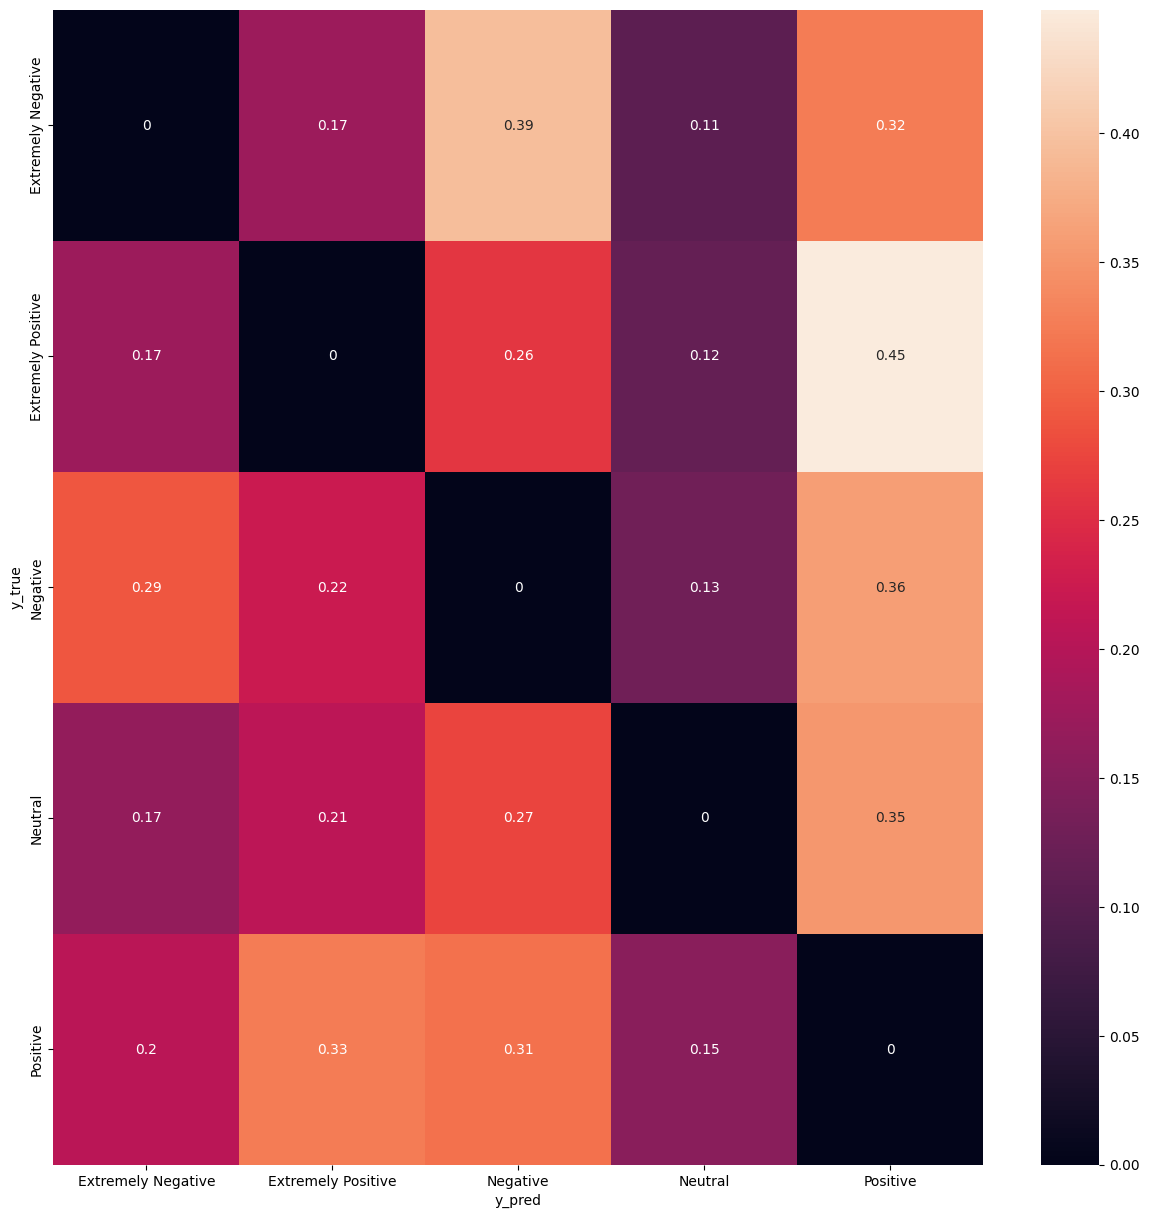

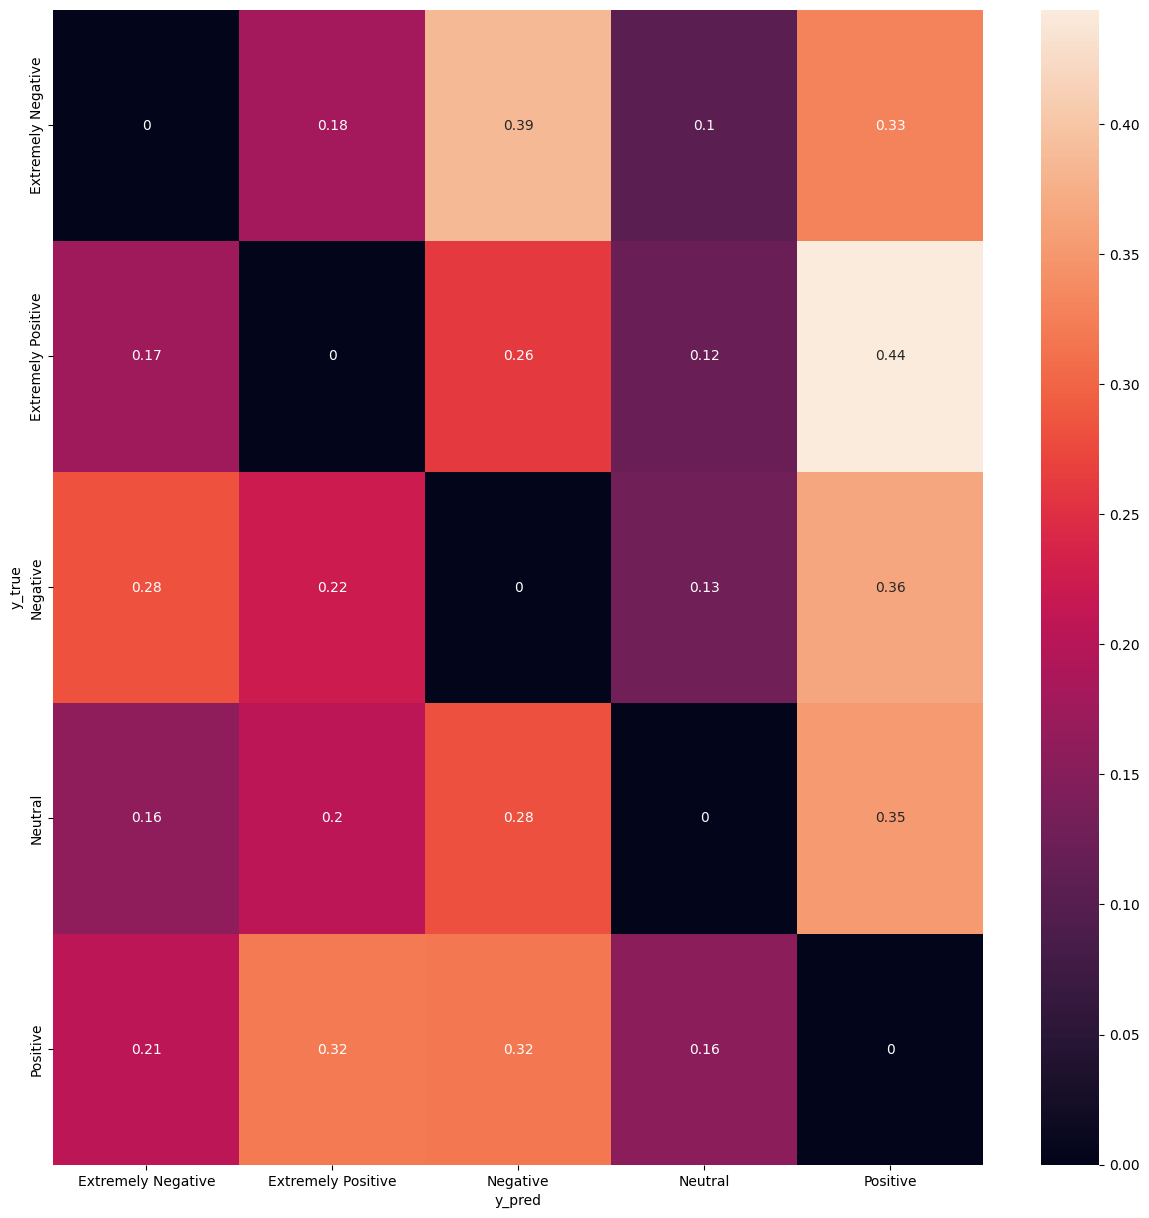

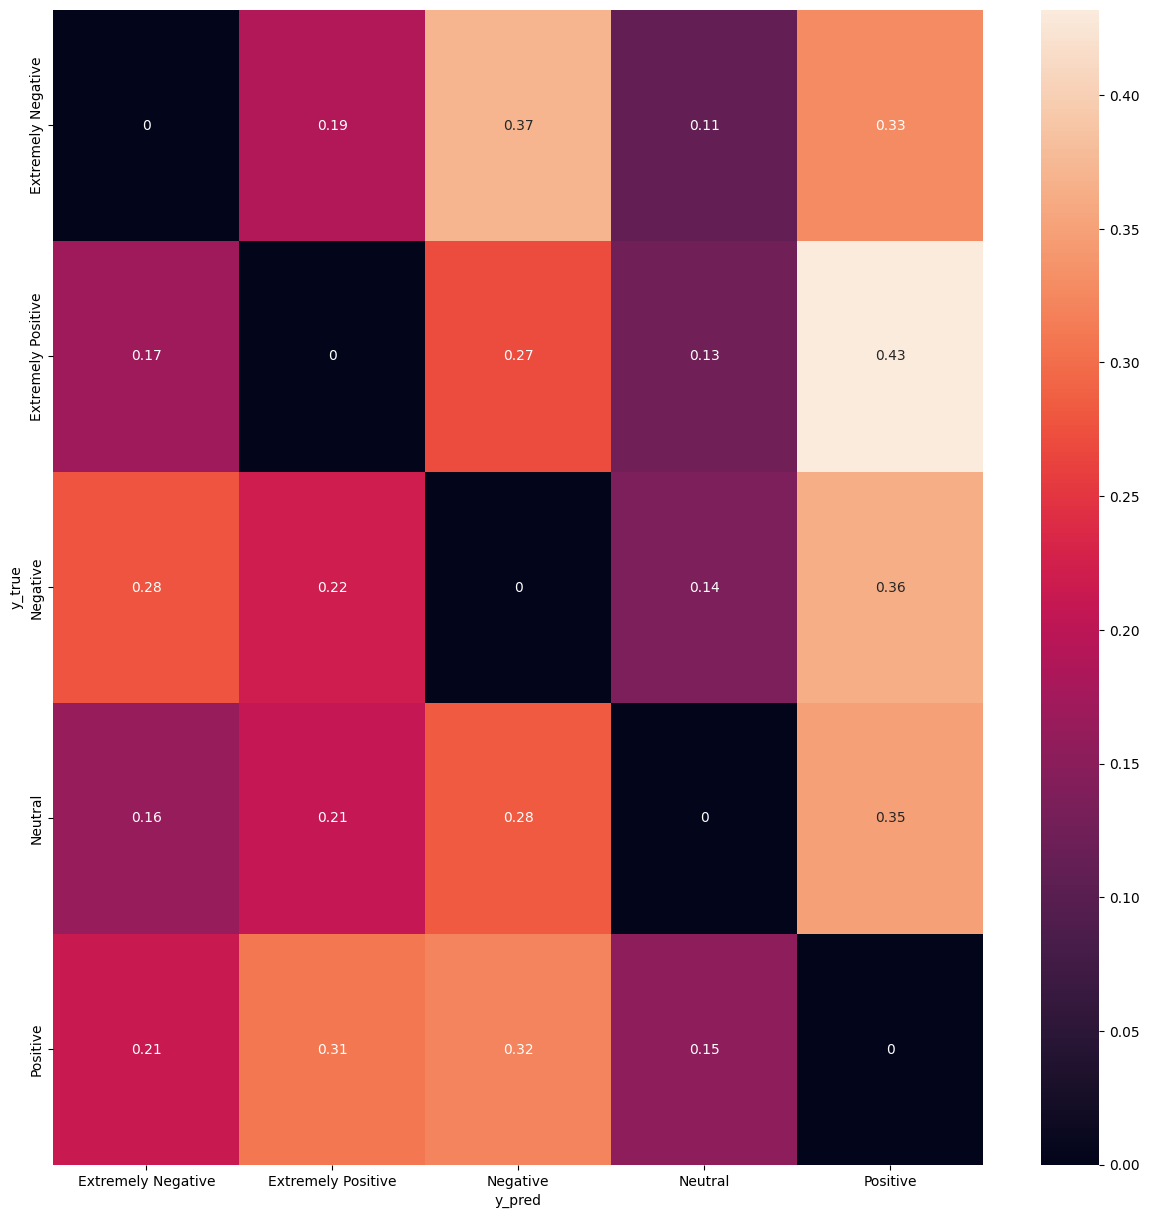

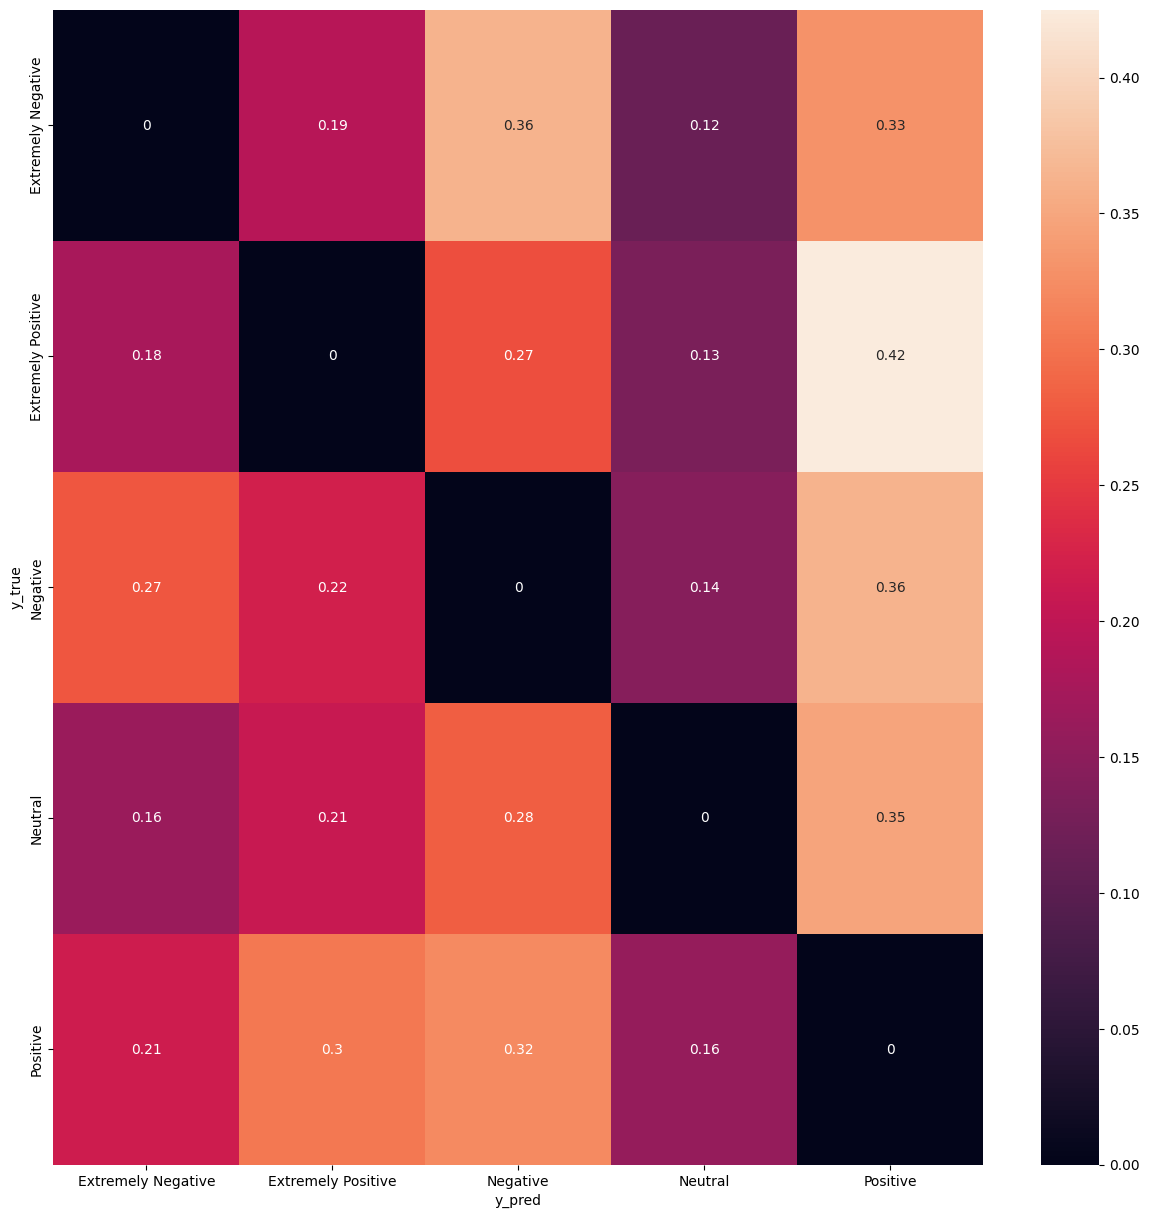

In [107]:
for prec in precisions_calc:
    v = pd.DataFrame(np.around(fill_diagonal(cf_per_prec_bm25[prec], 0)/(fill_diagonal(cf_per_prec_bm25[prec], 0).sum(axis=1)).reshape(-1, 1), 3), columns=labels, index=labels)
    
    fig = plt.figure(figsize=(15, 15))
    sns.heatmap(v, annot=True)
    plt.ylabel('y_true')
    plt.xlabel('y_pred')
    fig.savefig(f'figures-corona/cf_matrix/cf_bm25_diagonal_0_{prec}.png', bbox_inches='tight')